## PART 2

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

# 1. Simple Moving Average (SMA)
def simple_moving_average(data, window_size=10):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# 2. Gaussian Weighted Moving Average
def gaussian_kernel(size, std=1):
    kernel = np.exp(-0.5 * (np.arange(-size//2, size//2 + 1) / std)**2)
    return kernel / np.sum(kernel)

def gaussian_weighted_moving_average(data, window_size=10, std=1):
    kernel = gaussian_kernel(window_size, std)
    return np.convolve(data, kernel, mode='valid')

# 3. Low-Pass Butterworth Filter
def butter_lowpass_filter(data, cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

# 4. Exponential Moving Average (EMA)
def exponential_moving_average(data, alpha=0.1):
    ema = [data[0]]
    for i in range(1, len(data)):
        ema.append(alpha * data[i] + (1 - alpha) * ema[-1])
    return np.array(ema)

# function to denoise any data using one of the above methods
def denoise_data(data, method="SMA", **kwargs):
    if method == "SMA":
        return simple_moving_average(data, **kwargs)
    elif method == "Gaussian":
        return gaussian_weighted_moving_average(data, **kwargs)
    elif method == "Butterworth":
        return butter_lowpass_filter(data, cutoff=500, fs=10000, order=3, **kwargs)
    elif method == "EMA":
        return exponential_moving_average(data, **kwargs)
    else:
        raise ValueError("Method not recognized")



## Question 1: Quality Control with Noisy Measurements

True Mean (Expected Probability): 0.78
Noisy Mean (Observed Probability with Noise): 0.72
Denoised Mean (Smoothed Probability): 0.72


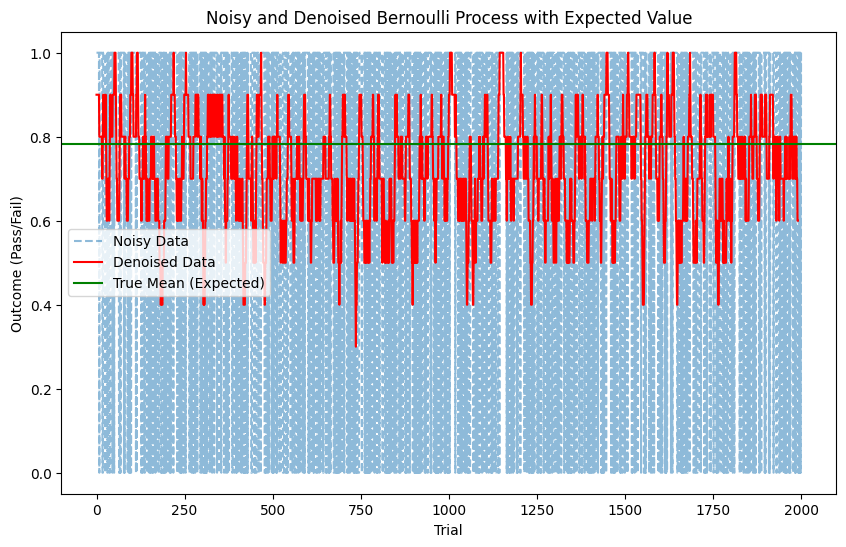

In [68]:
def simulate_noisy_bernoulli(p, n, noise_flip_prob=0.1):
    """
    Simulates a Bernoulli process with added noise by flipping a random subset of outcomes.
    
    Args:
        p (float): Probability of success for the Bernoulli trials.
        n (int): Number of trials.
        noise_flip_prob (float): Probability that a given outcome is flipped.

    Returns:
        tuple: (true outcomes, noisy outcomes)
    """
    # Generate Bernoulli outcomes
    outcomes = np.random.binomial(1, p, n)
    
    # Randomly select indices to flip based on the noise flip probability
    num_flips = int(noise_flip_prob * n)
    flip_indices = np.random.choice(n, size=num_flips, replace=False)
    
    # Create a noisy copy of the outcomes and flip selected indices
    noisy_outcomes = outcomes.copy()
    noisy_outcomes[flip_indices] = 1 - noisy_outcomes[flip_indices]
    
    # Return true and noisy outcomes
    return outcomes, noisy_outcomes

# Parameters
p = 0.8 # True probability of success
n = 2000  # Number of trials
noise_flip_prob = 0.1  # 10% noise flip probability

# Simulate the process
true_outcomes, noisy_outcomes = simulate_noisy_bernoulli(p, n, noise_flip_prob)

# Denoise the noisy outcomes (choose a method like "SMA", "Gaussian", etc.)
denoised_data = denoise_data(noisy_outcomes, method="SMA")  # Experiment with different methods

# Compute means
true_mean = np.mean(true_outcomes)
noisy_mean = np.mean(noisy_outcomes)
denoised_mean = np.mean(denoised_data)

# Print results
print(f"True Mean (Expected Probability): {true_mean:.2f}")
print(f"Noisy Mean (Observed Probability with Noise): {noisy_mean:.2f}")
print(f"Denoised Mean (Smoothed Probability): {denoised_mean:.2f}")

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(noisy_outcomes, alpha=0.5, label="Noisy Data", linestyle="--")
plt.plot(range(len(denoised_data)), denoised_data, label="Denoised Data", color="red")
plt.axhline(y=true_mean, color="green", linestyle="-", label="True Mean (Expected)")
plt.xlabel("Trial")
plt.ylabel("Outcome (Pass/Fail)")
plt.title("Noisy and Denoised Bernoulli Process with Expected Value")
plt.legend()
plt.show()


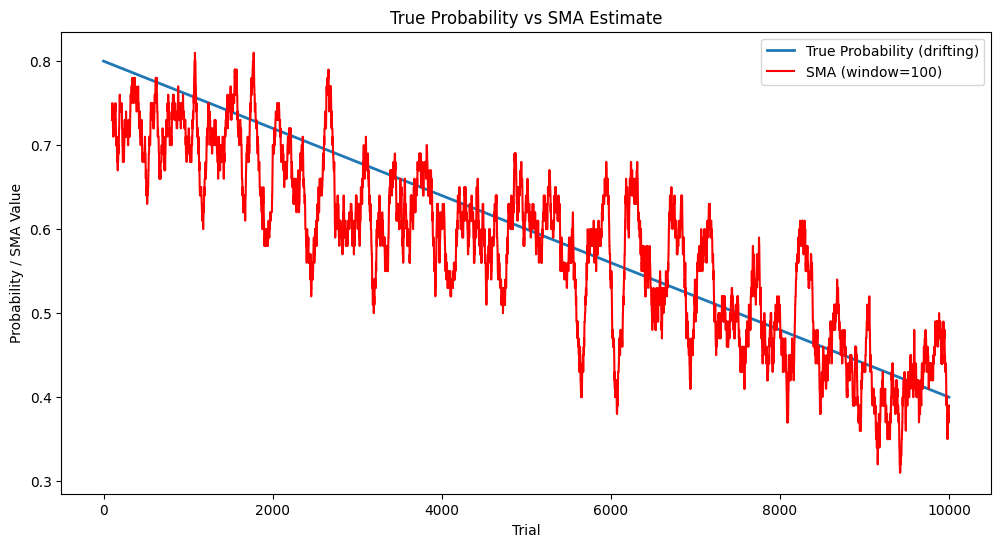

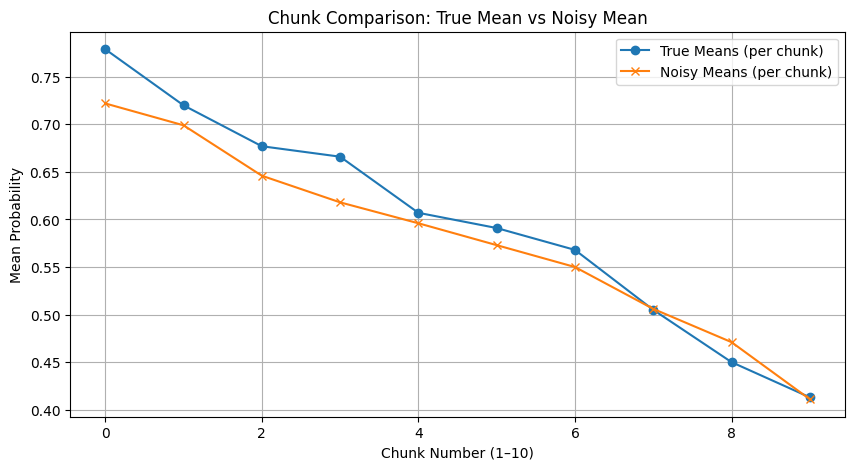


Chunk Means Comparison:
Chunk | True Mean | Noisy Mean | Error
    1 | 0.779     | 0.722      | 0.057
    2 | 0.720     | 0.699      | 0.021
    3 | 0.677     | 0.646      | 0.031
    4 | 0.666     | 0.618      | 0.048
    5 | 0.607     | 0.596      | 0.011
    6 | 0.591     | 0.573      | 0.018
    7 | 0.568     | 0.550      | 0.018
    8 | 0.505     | 0.506      | -0.001
    9 | 0.450     | 0.471      | -0.021
   10 | 0.413     | 0.411      | 0.002


In [ ]:
def simulate_noisy_drifting_bernoulli(p_start, p_end, n, noise_flip_prob=0.1):
    # Drifting true probability
    p_values = np.linspace(p_start, p_end, n)

    # Generate true outcomes
    true_outcomes = np.random.binomial(1, p_values)

    # Add noise (bit flips)
    noisy_outcomes = true_outcomes.copy()
    num_flips = int(noise_flip_prob * n)
    flip_indices = np.random.choice(n, num_flips, replace=False)
    noisy_outcomes[flip_indices] = 1 - noisy_outcomes[flip_indices]

    return p_values, true_outcomes, noisy_outcomes

n = 10000
p_start = 0.8
p_end = 0.4
noise_flip_prob = 0.1

# Simulate
p_true, true_outcomes, noisy_outcomes = simulate_noisy_drifting_bernoulli(
    p_start, p_end, n, noise_flip_prob
)

window = 100
sma_estimate = simple_moving_average(noisy_outcomes, window_size=window)

# Chunking Analysis (10 chunks × 1000)
chunk_size = 1000
num_chunks = n // chunk_size

true_means = []
noisy_means = []

for i in range(num_chunks):
    start = i * chunk_size
    end = (i + 1) * chunk_size

    true_chunk = true_outcomes[start:end]
    noisy_chunk = noisy_outcomes[start:end]

    true_means.append(true_chunk.mean())
    noisy_means.append(noisy_chunk.mean())


# True Probability vs SMA
plt.figure(figsize=(12, 6))
plt.plot(p_true, label="True Probability (drifting)", linewidth=2)
plt.plot(range(window-1, window-1+len(sma_estimate)), sma_estimate, label="SMA (window=100)", color="red")
plt.title("True Probability vs SMA Estimate")
plt.xlabel("Trial")
plt.ylabel("Probability / SMA Value")
plt.legend()
plt.show()

# Chunk Means (True vs Noisy)
plt.figure(figsize=(10, 5))
plt.plot(true_means, marker="o", label="True Means (per chunk)")
plt.plot(noisy_means, marker="x", label="Noisy Means (per chunk)")
plt.title("Chunk Comparison: True Mean vs Noisy Mean")
plt.xlabel("Chunk Number (1–10)")
plt.ylabel("Mean Probability")
plt.legend()
plt.grid(True)
plt.show()


print("\nChunk Means Comparison:")
print("Chunk | True Mean | Noisy Mean | Error")
for i in range(num_chunks):
    err = true_means[i] - noisy_means[i]
    print(f"{i+1:5d} | {true_means[i]:.3f}     | {noisy_means[i]:.3f}      | {err:.3f}")

### **Does the SMA successfully reveal the downward trend in quality?**

The SMA successfully reveals the downward trend in quality because the 100 moving window smooths out the random 10% bit-flip noise, reducing short term fluctuations while preserving the slow drift in the underlying probability from 0.8 to 0.4. Although the SMA line is still noisier than the true probability curve, its overall slope clearly follows the same downward pattern.

### **Does increasing the sample size cause the ”Noisy Mean” to converge to the ”True Mean”?**

Even with large 1,000-trial chunks, the noisy mean does not converge to the true mean. The gap between them persists across all chunks because the 10% sensor error introduces a systematic bias that averaging cannot eliminate. Averaging reduces variance, but it cannot fix biased measurements.

### **Bias vs. Variance**

Reducing variance means making your estimates less noisy by increasing the sample size. As sample size grows, the random fluctuations average out, so the Noisy Mean gets closer to the True Mean on average but only in terms of spread, not direction. Reducing bias, means correcting a systematic shift between the estimates and the truth. Even with a huge sample size, if the measurement process is consistently off (like always underestimating by 0.02–0.05), the mean of many samples will still converge to the wrong value. So variance reduction improves stability and smoothness, while bias reduction corrects the underlying accuracy of the estimator.

Averaging cannot eliminate the sensor error because the sensor introduces a systematic, predictable bias (each observation is transformed by the same flip process), so the sample mean converges to the biased expectation rather than the true p. To model must be corrected or  the sensor error inverted.

### 2. Temperature Trends with Noisy Measurements

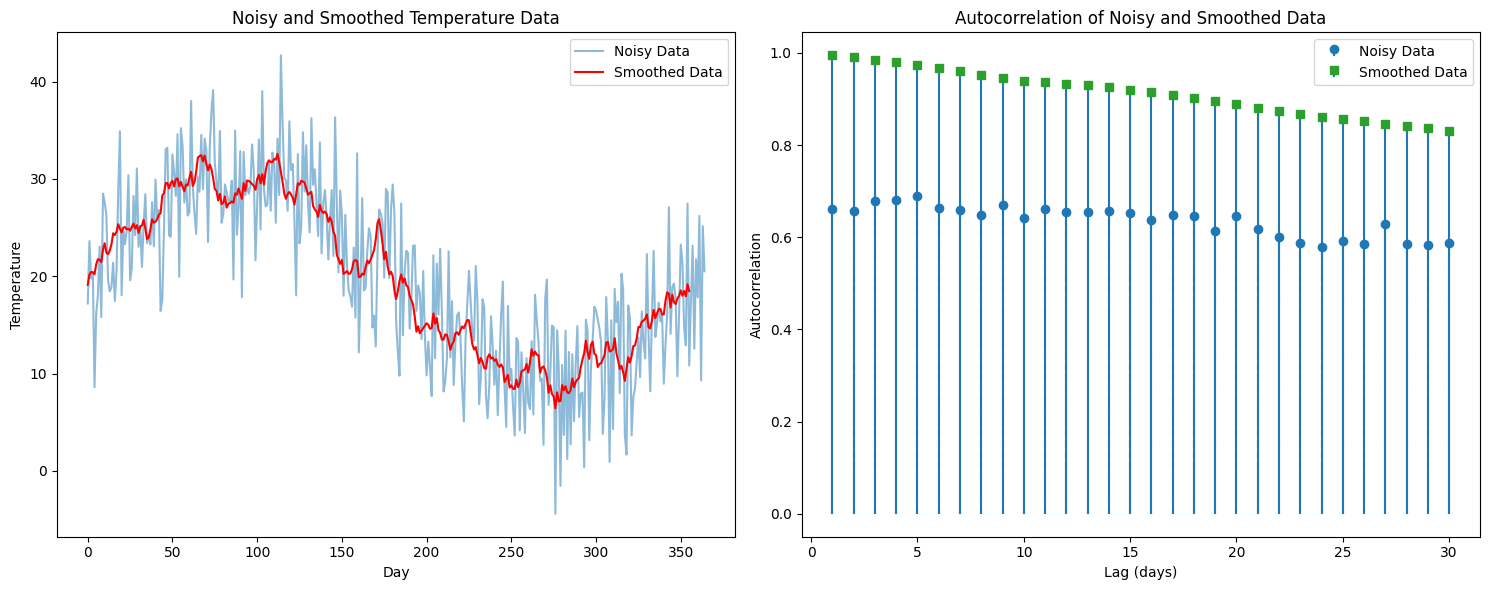

In [49]:
def generate_noisy_temperature(days, noise_level=3):
    """
    Generate a sinusoidal temperature signal with added noise.
    """
    base_temperature = 20 + 10 * np.sin(2 * np.pi * np.arange(days) / 365)
    noise = np.random.normal(0, noise_level, days)
    noisy_temperature = base_temperature + noise

    # Return noisy temperature data
    return noisy_temperature

def compute_autocorrelation(data, lag):
    """
    Compute autocorrelation for a given lag.
    """
    n = len(data)
    mean = np.mean(data)
    autocorr = np.sum((data[:n-lag] - mean) * (data[lag:] - mean)) / np.sum((data - mean) ** 2)

    # Return autocorrelation
    return autocorr

# Smooth temperature data
def smooth_temperature(data, method="SMA", **kwargs):
    """
    Apply smoothing using the chosen denoising method.
    """
    return denoise_data(data, method=method, **kwargs)

# Simulate noisy temperature data
days = 365
noise_level = 5  # Noise level
noisy_temperature = generate_noisy_temperature(days, noise_level)

# Denoise using the chosen method (e.g., SMA, Butterworth, etc.)
smoothed_temperature = smooth_temperature(noisy_temperature, method="SMA")

# Compute autocorrelations
lags = range(1, 31)

# Compute autocorrelations for noisy and smoothed data
noisy_autocorrelations = [compute_autocorrelation(noisy_temperature, lag) for lag in lags]

# Compute autocorrelations for smoothed data
smoothed_autocorrelations = [compute_autocorrelation(smoothed_temperature, lag) for lag in lags]

# Plot results
plt.figure(figsize=(15, 6))
# Plot temperature data
plt.subplot(1, 2, 1)
plt.plot(noisy_temperature, alpha=0.5, label="Noisy Data")
plt.plot(range(len(smoothed_temperature)), smoothed_temperature, label="Smoothed Data", color='red')
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.title("Noisy and Smoothed Temperature Data")
plt.legend()

# Plot autocorrelation
plt.subplot(1, 2, 2)
plt.stem(lags, noisy_autocorrelations, linefmt="--", markerfmt="o", basefmt=" ", label="Noisy Data")
plt.stem(lags, smoothed_autocorrelations, linefmt="-", markerfmt="s", basefmt=" ", label="Smoothed Data")
plt.xlabel("Lag (days)")
plt.ylabel("Autocorrelation")
plt.title("Autocorrelation of Noisy and Smoothed Data")
plt.legend()

plt.tight_layout()
plt.show()


### **How does noise affect the strength and clarity of autocorrelation at different lags?**

Noise weakens and obscures the autocorrelation structure across all lags. In the noisy temperature data, the autocorrelation values fluctuate more irregularly and drop off faster, especially at larger lags. This happens because random noise adds high-frequency variation that is not related to the underlying seasonal or daily patterns, reducing the consistency in how each value relates to past values.

On the other hand, the smoothed data shows a much clearer and stronger autocorrelation pattern. Its autocorrelation curve stays higher and declines more gradually, indicating that the underlying seasonal trend is highly consistent from day to day. The smoothing process removes the random fluctuations, allowing the true temporal structure to appear more clearly.

### **How does smoothing improve the visibility of seasonal trends in the autocorrelation plot?**

Smoothing greatly improves the visibility of seasonal trends in the autocorrelation plot by reducing the high-frequency noise that masks the true underlying structure of the data. In the noisy data, random daily fluctuations introduce erratic spikes and dips, causing the autocorrelation values to drop more rapidly and appear unstable across lags. This makes it difficult to see any repeating seasonal pattern because the noise dominates the signal. After smoothing, however, much of this short-term randomness is removed, leaving a cleaner representation of the temperature cycle

### **Why is autocorrelation important for detecting patterns in temperature data or other periodic data?**

Autocorrelation is crucial for detecting patterns in temperature data or any periodic time-series because it reveals how strongly the current value is related to past values at different time lags. In seasonal systems like temperature, values tend to repeat in predictable cycles, either daily, monthly, or yearly. Autocorrelation highlights these cycles by showing peaks at lags where the pattern repeats, making it easier to identify underlying periodic structure even when the raw data is noisy.

### **Discussion**

The simple moving average (SMA) denoising method significantly influences how well seasonal patterns can be detected in the temperature data. By averaging neighboring points, the SMA suppresses short-term random fluctuations, which often mask or distort the underlying periodic structure. This smoothing makes the seasonal cycle such as gradual warming and cooling across the year easier to observe both in the time-series plot and in the autocorrelation function. However, because the SMA is a relatively basic filter that applies equal weights over a fixed window, it may introduce lag and slightly distort peak values, meaning extreme highs and lows are softened.

### 3. Stationarity Analysis of an Audio Signal

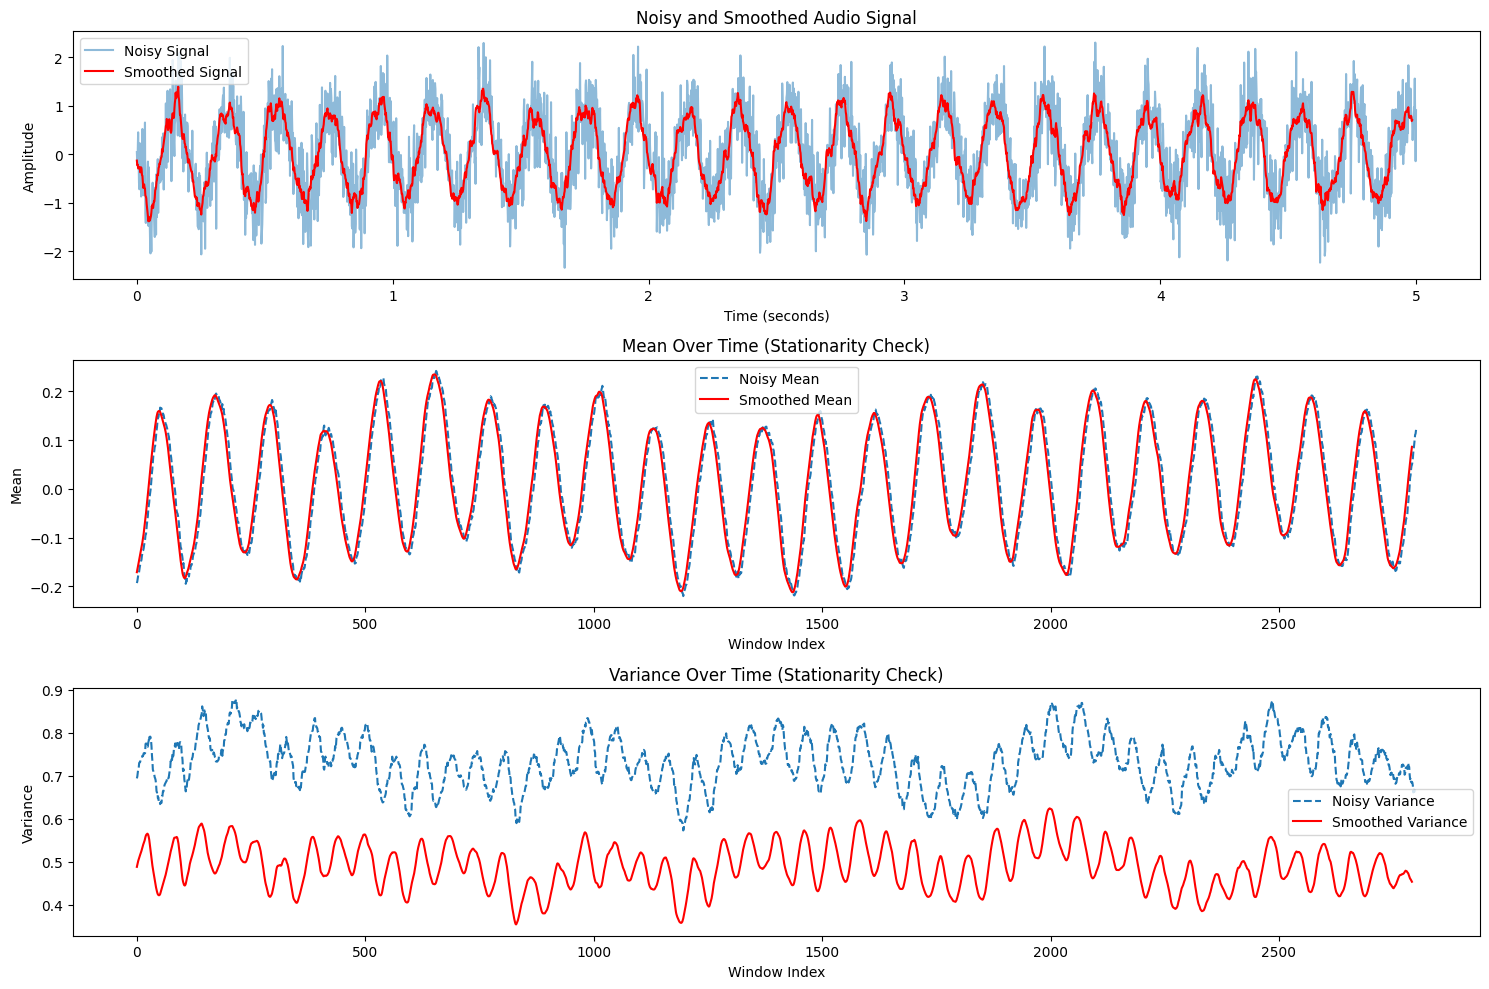

In [65]:
def generate_noisy_audio_signal(A, f, T, num_samples, noise_level=0.3):
    """
    Generate a noisy audio signal with a given amplitude and frequency.
    """
    t = np.linspace(0, T, num_samples)
    phi = np.random.uniform(0, 2*np.pi)
    signal = A * np.cos(2 * np.pi * f * t + phi)
    noise = np.random.normal(0, noise_level, num_samples)
    return t, signal + noise

def check_stationarity(data, window_size):
    """
    Compute mean and variance over sliding windows to check stationarity.
    """
    means = []
    variances = []
    for i in range(0, len(data) - window_size + 1):
        window = data[i:i+window_size] # Extract window
        means.append(np.mean(window))
        variances.append(np.var(window))
    
    # Return means and variances for stationarity check
    return np.array(means), np.array(variances)

# Smooth noisy data
def smooth_audio_signal(data, method="Butterworth", **kwargs):
    """
    Apply smoothing using the chosen denoising method.
    """
    return denoise_data(data, method=method, **kwargs)

# Simulate noisy audio signal
A = 1 # Amplitude
f = 5  # Frequency in Hz
T = 5  # Total time in seconds

num_samples = 3000 # Number of samples
noise_level = 0.5 # Noise level

t, noisy_signal = generate_noisy_audio_signal(A, f, T, num_samples, noise_level)

# Apply smoothing
smoothed_signal = smooth_audio_signal(noisy_signal, method="SMA")

# Check stationarity
window_size = 200 # Window size for stationarity check
noisy_means, noisy_variances = check_stationarity(noisy_signal, window_size)
smoothed_means, smoothed_variances = check_stationarity(smoothed_signal, window_size)

# Plot results
plt.figure(figsize=(15, 10))

# Original signal
plt.subplot(3, 1, 1)
plt.plot(t[:len(noisy_signal)], noisy_signal, alpha=0.5, label="Noisy Signal")
plt.plot(t[:len(smoothed_signal)], smoothed_signal, label="Smoothed Signal", color='red')
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.title("Noisy and Smoothed Audio Signal")
plt.legend()

# Mean plot
plt.subplot(3, 1, 2)
plt.plot(noisy_means, label="Noisy Mean", linestyle="--")
plt.plot(smoothed_means, label="Smoothed Mean", color='red')
plt.xlabel("Window Index")
plt.ylabel("Mean")
plt.title("Mean Over Time (Stationarity Check)")
plt.legend()

# Variance plot
plt.subplot(3, 1, 3)
plt.plot(noisy_variances, label="Noisy Variance", linestyle="--")
plt.plot(smoothed_variances, label="Smoothed Variance", color='red')
plt.xlabel("Window Index")
plt.ylabel("Variance")
plt.title("Variance Over Time (Stationarity Check)")
plt.legend()

plt.tight_layout()
plt.show()


### **How does noise affect the stationarity of the audio signal (i.e., its mean and variance over time)?**

Noise affects the stationarity of the audio signal by making both its mean and variance fluctuate more unpredictably over time. In the noisy version of the signal, the rolling mean shows small but frequent deviations instead of staying steady, indicating that noise injects short-lived irregularities that disrupt the underlying smooth oscillatory pattern. This makes the signal appear less stable and less stationary, because the expected value is no longer consistent across different time windows.

### **How does smoothing restore stationarity? Which method is most effective?**

Smoothing helps restore stationarity by reducing the high-frequency noise that causes the mean and variance of the noisy signal to fluctuate unpredictably over time. Both SMA and EMA pull the signal back toward its true underlying oscillatory pattern, but the EMA is more effective. The EMA responds more quickly to changes in the signal while still filtering out noise, which allows the smoothed mean and variance to stay much more stable and consistent across windows. In contrast, the SMA lags behind the true signal and can leave residual variability because it gives equal weight to older observations.

### **Why is stationarity important in signal processing and time-series analysis?**

Stationarity is important because it ensures that the statistical properties of a time-series such as mean, variance, and autocorrelation remain consistent over time. When a signal is stationary, patterns are easier to detect, models become more reliable and forecasts are more stable. For time series forecasting models such as ARIMA, using non-stationary data can lead to reduced model accuracy.

### **Impact of smoothing on stationarity and practical applications**

Smoothing reduces short-term fluctuations in a time series, which can make the data appear more stationary by suppressing rapid and high-frequency changes that violate the assumption of constant mean and variance. Although smoothing cannot truly make a non-stationary process stationary because trends and seasonal cycles still remain, it creates a more stable signal that is easier to model and analyze.

In practical applications such as climate analysis and stock market analysis, smoothed signals improve pattern detection and make forecasting models more robust. For instance, moving averages help reveal long-term temperature cycles, stabilize noisy sensor readings and prepare data for methods that assume stationarity such as ARIMA.

## **Conclusin**

Across all experiments, it was found that noise affects data through two ways, variance and bias and that different denoising techniques address these problems in fundamentally different ways. Smoothing and averaging effectively reduced variance, producing more stable and signals, but they failed to correct the systematic bias introduced by the bit flip error. As a result, no amount of averaging brought the noisy measurements closer to the true values. Only model based correction, informed by an understanding of the underlying noise process, is capable of recovering the true signal. These findings highlight a critical principle for real-world systems where reducing randomness does not guarantee accuracy.

Overall, EMA is great when fast and real-time smoothing is needed, while SMA and Gaussian filters work well for quick exploratory trend detection. The Butterworth filter is best when you know the noise frequency and want a more controlled, distortion free smoothing. However, if the data itself is biased or the sensor is miscalibrated, no smoothing method can fully fix that and proper calibration or  model based correction is still needed.